# Detecting Fake Job Postings with Machine Learning

#### Project Storyline: Fighting Fraud in the Job Market

In today’s digital age, millions of online job platforms have become targets for scammers posting fake jobs to steal personal data or charge fake fees. These fraudulent listings erode trust and waste job seekers' time. To help job boards maintain safety and efficiency. These fraudulent jobs often:

- Collect personal information under false pretenses
- Charge fake application or training fees
- Waste job seekers’ time and damage their trust

To protect users and improve trust in online job boards, we aim to build a machine learning model that flags suspicious job postings.

##### Stakeholder
The key stakeholder is online job platforms (e.g., LinkedIn, Indeed). They aim to protect job seekers from scams, maintain trust, and reduce manual moderation by using automated fake job detection.

##### Objective

Build a classification model that can predict whether a job listing is **fraudulent (1)** or **legitimate (0)** based on its content.

##### Business Questions
1. Can we predict fake job postings based on content like description, location, and telecommuting?

2. Which features are most predictive of fraudulent listings?

3. How well can we catch fake listings without misclassifying too many real ones?

4. How can this model be used to assist or automate moderation workflows?

##### Why Machine Learning?

Rule-based systems can’t keep up with evolving scams. With machine learning, we can:

- Learn from patterns across thousands of job postings
- Automatically detect suspicious listings
- Support human moderators with predictions

##### Dataset

We’ll use the “Fake Job Postings” dataset from [Kaggle](https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction). The dataset includes real and fake job posts, with features such as:

- Job title, company, location
- Description, requirements, benefits
- Telecommuting, company logo, employment type

Our target variable is:
- `fraudulent`: 0 = Real job, 1 = Fake job

---

### **Let’s begin by importing the dataset and exploring the data.**


In [434]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

df = pd.read_csv("../data/fake_job_postings.csv")
df.head()


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [435]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [436]:
print("Dataset shape (rows, columns):", df.shape)

Dataset shape (rows, columns): (17880, 18)


In [437]:
# Check missing values count per column
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64


##### Handling Missing Values

The dataset has several columns with missing values. Before building our model, it's important to decide how to handle these gaps. 

- Columns with too many missing values might be dropped or carefully imputed.
- Important features with few missing values can be filled with sensible defaults or placeholders.
- The target variable `fraudulent` has no missing data, so we don't need to worry about it.
---
##### **Let’s explore and handle missing values step-by-step.**


In [438]:
# fill missing text columns with "uknown"
text_columns = ['company_profile', 'benefits', 'requirements', 'description']
for columns in text_columns:
    df[columns] = df[columns].fillna('unknown')


In [439]:
# filling in missing categorical columns with mode
categorical_columns = ['department', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']
for columns in categorical_columns:
    mode = df[columns].mode()[0]
    df[columns] = df[columns].fillna(mode)

In [440]:
# Filling in missing in 'location' with "Unknown"
df['location'] = df['location'].fillna("unknown").str.strip()
df.loc[df['location'] == '', 'location'] = "unknown"

# Filling in missing in 'salary_range' with "Not Disclosed"
df['salary_range'] = df['salary_range'].fillna("Not Disclosed").str.strip()

# Checking some cleaned columns
df[['location', 'salary_range']].head(10)


,location,salary_range
0,"US, NY, New York",Not Disclosed
1,"NZ, , Auckland",Not Disclosed
2,"US, IA, Wever",Not Disclosed
3,"US, DC, Washington",Not Disclosed
4,"US, FL, Fort Worth",Not Disclosed
5,"US, MD,",Not Disclosed
6,"DE, BE, Berlin",20000-28000
7,"US, CA, San Francisco",Not Disclosed
8,"US, FL, Pensacola",Not Disclosed
9,"US, AZ, Phoenix",Not Disclosed


In [441]:
df.isnull().sum()

job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

---

After carefully inspecting the dataset, I performed data cleaning to prepare it for analysis and modeling:

- **Filled missing text fields** such as `company_profile`, `benefits`, `requirements`, and `description` with `"Unknown"` to avoid empty text entries.
- **Imputed missing categorical columns** like `department`, `employment_type`, `required_experience`, `required_education`, `industry`, and `function` using the most frequent value (mode) in each column.
- **Cleaned `location` column** by filling missing values with `"Unknown"` to handle incomplete geographic data.
- **Standardized `salary_range`** by filling missing or undisclosed salaries with `"Not Disclosed"`, which means the employer chose **not to publish or reveal** the salary for the position to keep data consistent.
- After cleaning, the dataset no longer contains missing values, making it ready for further analysis.

This cleaned dataset ensures better quality inputs for building our machine learning model to detect fake job postings.


In [442]:
# Saving the cleaned dataset to a new CSV file
df.to_csv("data/cleaned_fake_job_postings.csv", index=False)
print("Cleaned dataset saved successfully.")

Cleaned dataset saved successfully.


---
#### **Exploratory Data Analysis (EDA)**

In this section, we begin exploring the dataset to better understand the characteristics of job postings. This will help us identify patterns, trends, and potential red flags that differentiate real job listings from fraudulent ones.

We'll start with general EDA to get a high-level overview of the dataset, including:

- Basic structure and summary statistics
- Distribution of the target variable (`fraudulent`)
- Common job titles, locations, and companies
- Frequency of missing values
- Initial observations about salary and job posting metadata

This foundational understanding will guide our deeper analysis and help refine our approach for building a classification model.


In [443]:
# Shape and data types
print("Dataset shape:", df.shape)
print("\nData types:\n", df.dtypes)

# Summary statistics for numerical columns
print("\nSummary statistics (numerical):")
display(df.describe())

# Summary statistics for categorical columns
print("\nSummary statistics (categorical):")
display(df.describe(include='object'))


Dataset shape: (17880, 18)

Data types:
 job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

Summary statistics (numerical):


,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000



Summary statistics (categorical):


,title,location,department,salary_range,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function
count,17880,17880,17880,17880,17880,17880,17880,17880,17880,17880,17880,17880,17880
unique,11231,2991,1337,875,1710,14802,11969,6206,5,7,13,131,37
top,English Teacher Abroad,"GB, LND, London",Sales,Not Disclosed,unknown,"Play with kids, get paid for it Love travel? J...",unknown,unknown,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology
freq,311,736,12098,15012,3308,379,2695,7210,15091,10859,13250,6637,8204


Target Variable Overview

Our main goal is to predict whether a job posting is **fraudulent (1)** or **legitimate (0)**. 

Understanding the distribution of this target variable is crucial because:

- It tells us if the dataset is balanced or skewed towards one class.
- Imbalanced classes may require special handling during modeling.

##### **Let's take a look at how many fake vs real job postings we have in the dataset.**


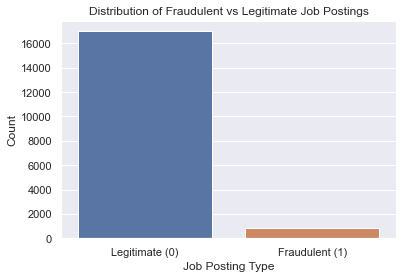

0    17014
1      866
Name: fraudulent, dtype: int64


In [444]:
import matplotlib.pyplot as plt

# plotting the distribution of the target variables
plt.figure(figsize=(6,4))
sns.countplot(x='fraudulent', data=df)
plt.title('Distribution of Fraudulent vs Legitimate Job Postings')
plt.xlabel('Job Posting Type')
plt.ylabel('Count')
plt.xticks(ticks=[0,1], labels=['Legitimate (0)', 'Fraudulent (1)'])
plt.show()

# let us also print counts to give the exact number behind the visual
print(df['fraudulent'].value_counts())

***Distribution of Fraudulent vs Legitimate Job Postings***

The bar plot shows the count of job postings labeled as either **Legitimate (0)** or **Fraudulent (1)**.

- The **x-axis** represents the job posting type:
  - **Legitimate (0)**: Genuine job postings.
  - **Fraudulent (1)**: Fake or scam job postings.

- The **y-axis** indicates the number of postings in each category.

From the plot, it is clear that legitimate postings greatly outnumber fraudulent ones. This means our dataset is imbalanced, with many more genuine listings than fake ones.

This class imbalance is important to consider in future modeling steps, as predictive models may become biased toward the majority (legitimate) class.

---

**Explore Categorical Features**

Here we visualize the distributions of key categorical variables to understand the common categories and any class imbalance within those features.


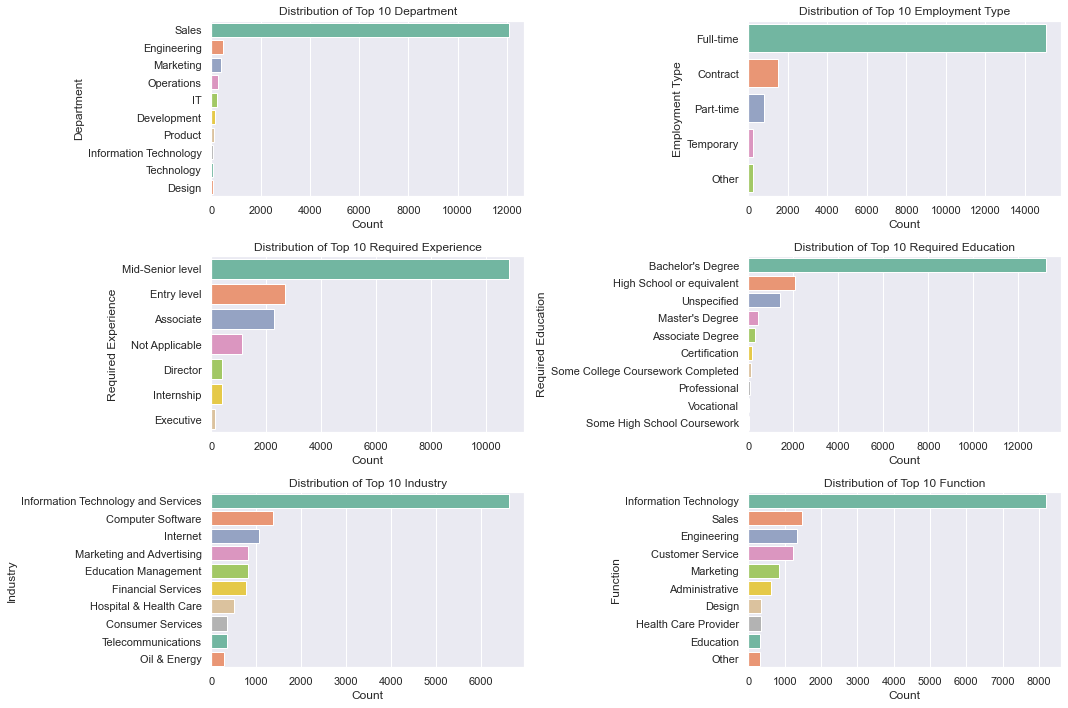

In [445]:
categorical_columns = ['department', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']

# Setting up the subplot grid of 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()


for i, column in enumerate(categorical_columns):
    top_values = df[column].value_counts().head(10)

    sns.barplot(x=top_values.values, y=top_values.index, ax=axes[i], palette='Set2')
    axes[i].set_title(f'Distribution of Top 10 {column.replace("_", " ").title()}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(column.replace("_", " ").title())

# Adjusting the layout to avoid overlapping
plt.tight_layout()
plt.show()


**Categorical Features vs Fraudulent Target**

These plots show how the different categories relate to whether a job posting is fraudulent or legitimate, revealing possible patterns or risk factors.


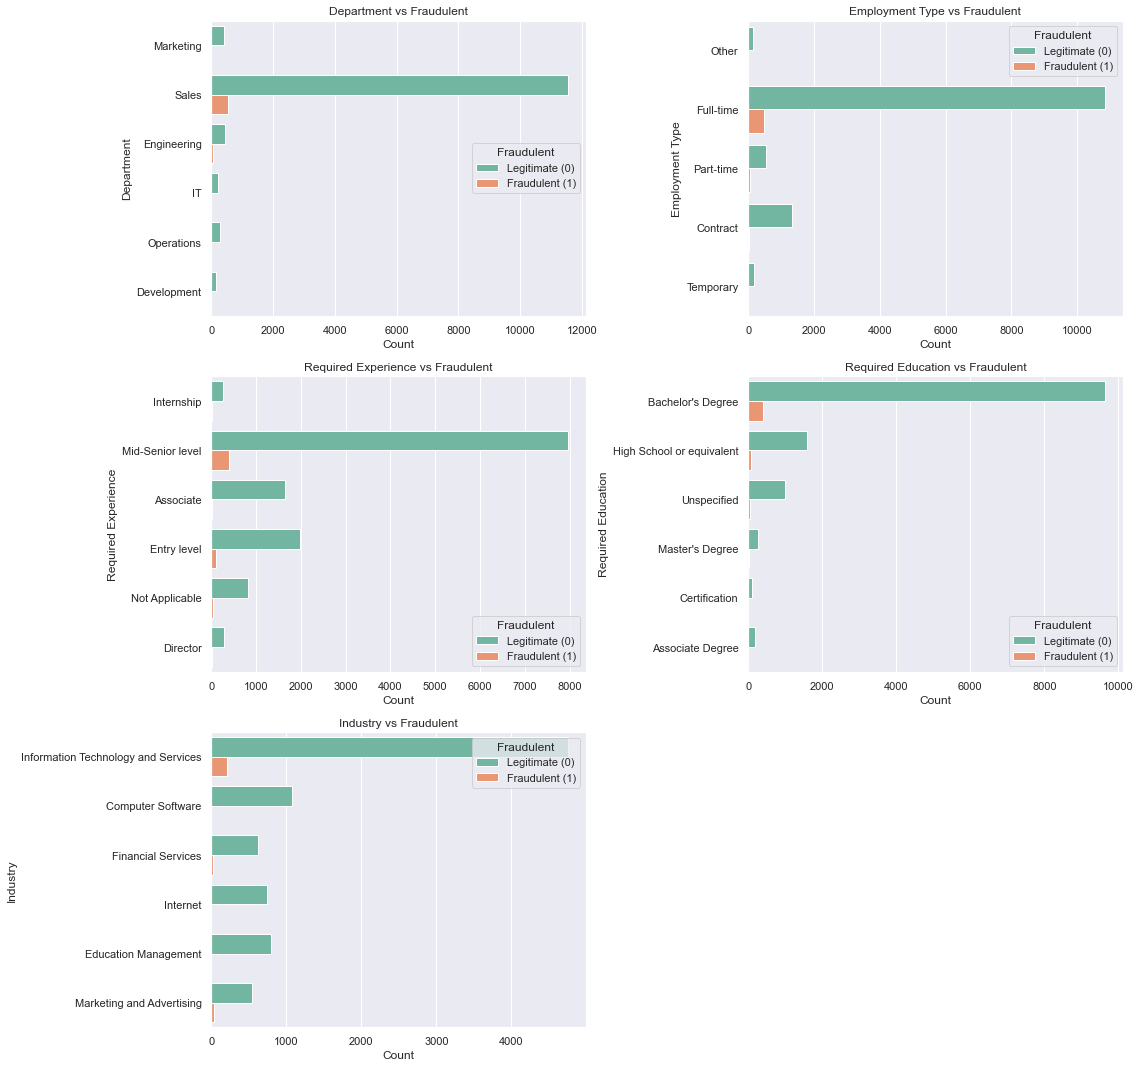

In [446]:
fig, axes = plt.subplots(3, 2, figsize=(16, 15))
axes = axes.flatten()

# plotting each features
for i, column in enumerate(categorical_columns):
    top_categories = df[column].value_counts().nlargest(6).index
    df = df[df[column].isin(top_categories)]

    sns.countplot(data=df, y=column, hue='fraudulent', ax=axes[i], palette='Set2')
    axes[i].set_title(f'{column.replace("_", " ").title()} vs Fraudulent')
    axes[i].set_xlabel("Count")
    axes[i].set_ylabel(column.replace("_", " ").title())
    axes[i].legend(title='Fraudulent', labels=['Legitimate (0)', 'Fraudulent (1)'])

# removing the unused subplots
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()



These plots show that fraudulent jobs tend to avoid requiring high experience, specific education, or commitment (like full-time work). They also appear in broad, easy-to-fake categories. This insight can guide your feature selection and model strategy later.

**Explore Text Columns Length**

Text length distributions in key columns might help us understand if fraudulent posts tend to have shorter or longer descriptions or requirements, which could be an important feature.



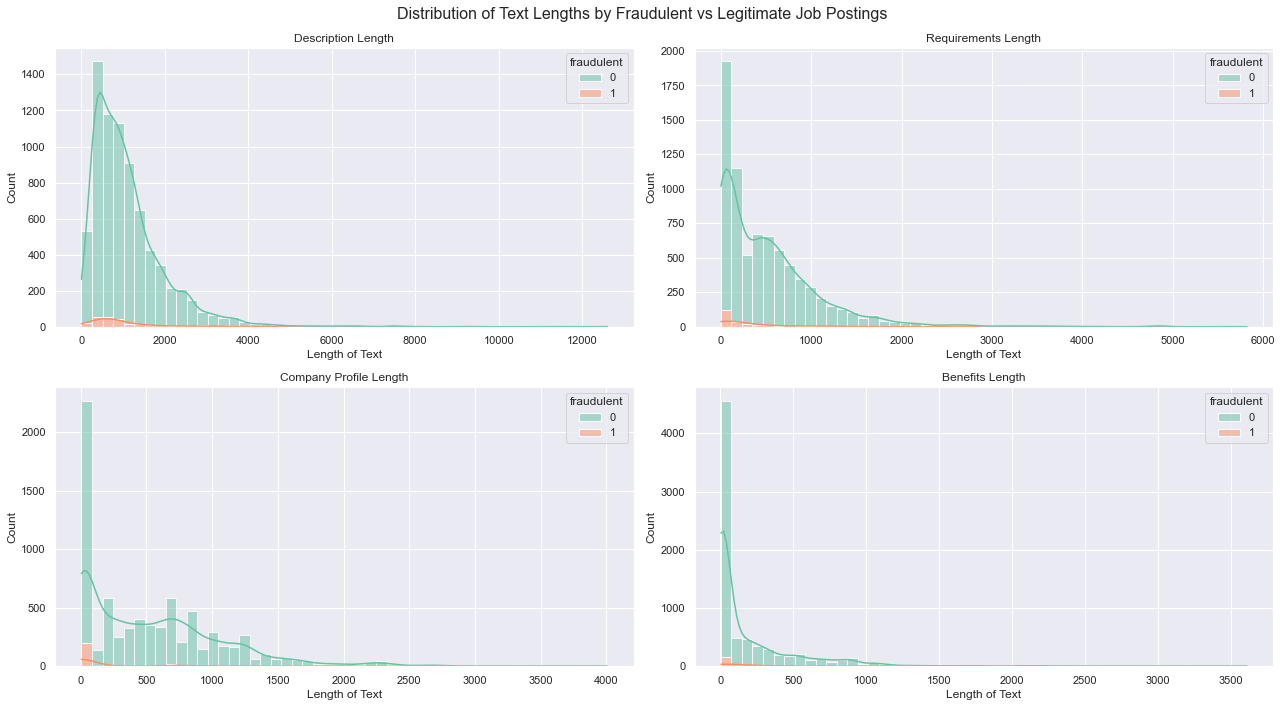

In [447]:
text_columns = ['description', 'requirements', 'company_profile', 'benefits']

# Creating new columns for text lengths
for column in text_columns:
    df[f'{column}_length'] = df[column].apply(lambda x: len(str(x)))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
fig.suptitle('Distribution of Text Lengths by Fraudulent vs Legitimate Job Postings', fontsize=16)
axes = axes.flatten()

for i, column in enumerate(text_columns):
    sns.histplot(data=df, x=f'{column}_length', hue='fraudulent', bins=50, kde=True, ax=axes[i], palette='Set2', multiple='stack')
    axes[i].set_title(f'{column.replace("_", " ").title()} Length')
    axes[i].set_xlabel('Length of Text')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()


Analyzing the length of key text fields (`description`, `requirements`, `company_profile`, `benefits`) and comparing them across fraudulent and legitimate job postings.

- **Description**: Legitimate jobs usually have longer, detailed descriptions. Fraudulent ones are shorter.
- **Requirements**: Real jobs list clear requirements. Fake ones often skip or keep it brief.
- **Company Profile**: Many are missing, but when present, legitimate jobs provide more info.
- **Benefits**: Most postings lack detailed benefits; not very useful for distinguishing fraud.

**Insight**: Short or missing text fields may signal fraudulent postings and can be useful features for modeling.


**Text Length by Fraudulent Status**
Box plots reveal that fraudulent job postings tend to have shorter or less consistent text content across fields like description, requirements, and company_profile. Legitimate postings usually show a wider range and longer average lengths, suggesting that fake jobs may use brief or templated content.


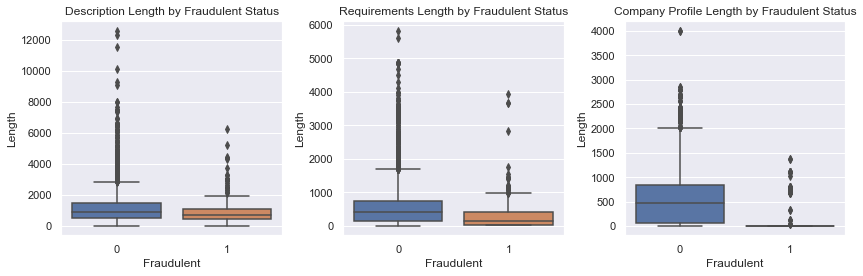

In [448]:
text_columns = ['description_length', 'requirements_length', 'company_profile_length']

plt.figure(figsize=(12, 4))
for i, column in enumerate(text_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='fraudulent', y=column, data=df)
    plt.title(f'{column.replace("_", " ").title()} by Fraudulent Status')
    plt.xlabel('Fraudulent')
    plt.ylabel('Length')
plt.tight_layout()
plt.show()


 **Correlation Heatmap for Numerical Columns**
 The correlation heatmap helps identify linear relationships between numerical variables and the target. Strong correlations can guide feature selection.


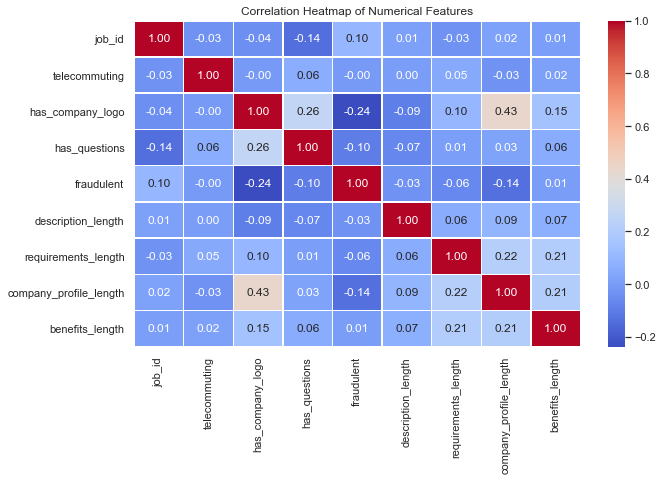

In [449]:
# Selecting only the numerical columns
numerical_columns = df.select_dtypes(include='number')

# Computing the correlation matrix
corr_matrix = numerical_columns.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


Plotting a correlation heatmap for all numerical columns, including the target variable `fraudulent`.

- The heatmap shows how strongly pairs of features are related (values range from -1 to 1).
- High positive values (close to 1) indicate a strong direct relationship.
- High negative values (close to -1) indicate a strong inverse relationship.
- Values near 0 suggest no linear correlation.

This helps us understand relationships between features and can guide feature selection for modeling.


**Location Analysis**

We analyze the most common job posting locations to identify any geographic patterns. This may help reveal whether certain locations are more associated with fraudulent job posts.


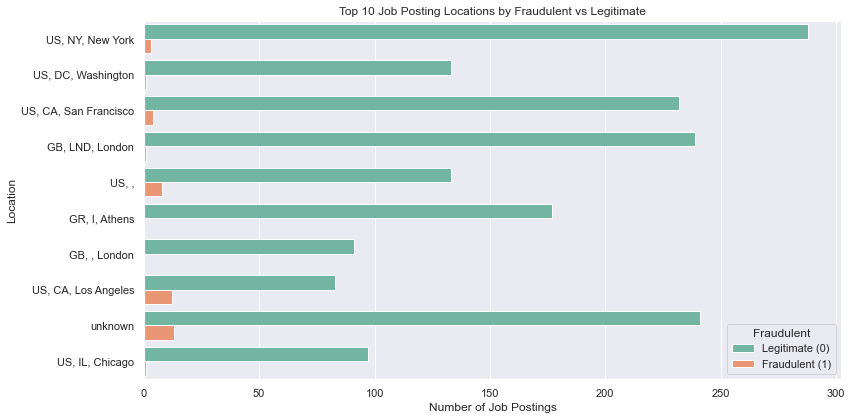

In [450]:
top_locations = df['location'].value_counts().head(10).index

# Filtering for only those top locations
top_location_df = df[df['location'].isin(top_locations)]

plt.figure(figsize=(12, 6))
sns.countplot(data=top_location_df, y='location', hue='fraudulent', palette='Set2')
plt.title('Top 10 Job Posting Locations by Fraudulent vs Legitimate')
plt.xlabel('Number of Job Postings')
plt.ylabel('Location')
plt.legend(title='Fraudulent', labels=['Legitimate (0)', 'Fraudulent (1)'])
plt.tight_layout()
plt.show()


The plot highlights the top 10 job posting locations. We can observe which cities or regions have a higher count of fraudulent job postings, helping identify any geographic risk factors.


**Fraud Rate by Top Locations**

This plot shows the proportion of fraudulent postings in each top location, highlighting riskier geographic areas.



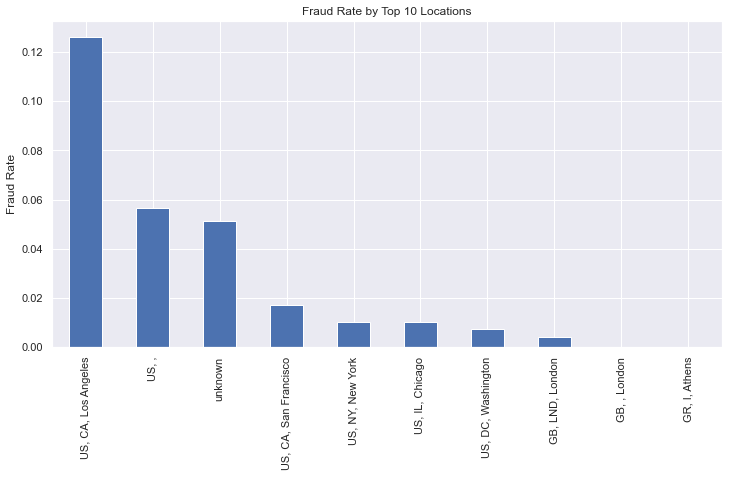

In [451]:
location_fraud_rate = df.groupby('location')['fraudulent'].mean().loc[top_locations].sort_values(ascending=False)
plt.figure(figsize=(12,6))
location_fraud_rate.plot(kind='bar')
plt.title('Fraud Rate by Top 10 Locations')
plt.ylabel('Fraud Rate')
plt.show()


**Final visualization of 3 strongest predictors**



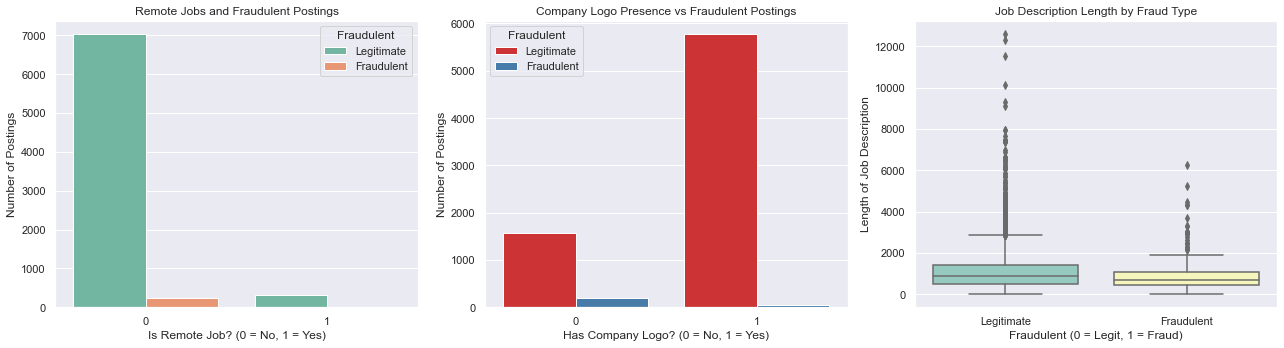

In [452]:
plt.figure(figsize=(18, 5))

# Telecommuting vs Fraudulent
plt.subplot(1, 3, 1)
sns.countplot(data=df, x='telecommuting', hue='fraudulent', palette='Set2')
plt.title('Remote Jobs and Fraudulent Postings')
plt.xlabel('Is Remote Job? (0 = No, 1 = Yes)')
plt.ylabel('Number of Postings')
plt.legend(title='Fraudulent', labels=['Legitimate', 'Fraudulent'])

# Has Company Logo vs Fraudulent
plt.subplot(1, 3, 2)
sns.countplot(data=df, x='has_company_logo', hue='fraudulent', palette='Set1')
plt.title('Company Logo Presence vs Fraudulent Postings')
plt.xlabel('Has Company Logo? (0 = No, 1 = Yes)')
plt.ylabel('Number of Postings')
plt.legend(title='Fraudulent', labels=['Legitimate', 'Fraudulent'])

# Description Length vs Fraudulent
plt.subplot(1, 3, 3)
sns.boxplot(data=df, x='fraudulent', y='description_length', palette='Set3')
plt.title('Job Description Length by Fraud Type')
plt.xlabel('Fraudulent (0 = Legit, 1 = Fraud)')
plt.ylabel('Length of Job Description')
plt.xticks([0, 1], ['Legitimate', 'Fraudulent'])

plt.tight_layout()
plt.show()

- **Remote Jobs**: Fraudulent job postings are more likely to be remote, possibly to avoid physical contact or verification.
- **Company Logo**: Legitimate job posts usually include a company logo, while fake ones often skip this detail.
- **Description Length**: Real job descriptions tend to be longer and more detailed. Fraudulent ones are often short and vague.

These patterns help us understand how scammers structure their listings differently from real employers.


#### **Finalizing the data preparation before modeling**

Let’s now proceed step by step to finalize the data preparation before modeling.

Before building any models, we need to make sure our dataset is fully clean and ready for feature engineering or training. This includes:

Checking for any remaining missing values

Confirming the data types are appropriate (e.g., categorical vs numerical)

Ensuring that the dataset has only the necessary, useful columns


In [453]:
# Confirm Null Handling
df.isnull().sum()

job_id                    0
title                     0
location                  0
department                0
salary_range              0
company_profile           0
description               0
requirements              0
benefits                  0
telecommuting             0
has_company_logo          0
has_questions             0
employment_type           0
required_experience       0
required_education        0
industry                  0
function                  0
fraudulent                0
description_length        0
requirements_length       0
company_profile_length    0
benefits_length           0
dtype: int64

### **Encode Categorical Features**

To prepare our data for machine learning models, we must convert categorical (text-based) columns into numeric values. Most machine learning algorithms work only with numbers — not raw text.

We will use two encoding techniques:

**Label Encoding**
- Ideal for columns with a lot of unique values (e.g., `title`, `description`, `company_profile`).
- Converts each unique category into a numeric label.
- Keeps dimensionality low, which avoids performance issues.

**One-Hot Encoding**
- Best for columns with fewer unique categories (e.g., `employment_type`, `required_education`).
- Creates a new column for each category and marks it with 0 or 1.
- Helps the model avoid misunderstanding numeric labels as having a ranked order.

**Why Encoding Matters:**
- It transforms text into a format the model understands.
- Helps the model learn meaningful patterns rather than treating text as gibberish.

We’ll apply:
- **Label encoding** on long-text fields to simplify them.
- **One-hot encoding** on clean categorical columns to preserve category uniqueness

In [454]:
from sklearn.preprocessing import LabelEncoder

# Create a copy of the dataframe to avoid modifying the original
df_encoded = df.copy()

# List of high-cardinality text fields — we’ll use Label Encoding
label_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits', 'location']

# Apply Label Encoding
label_encoder = LabelEncoder()
for column in label_columns:
    if column in df_encoded.columns:
        df_encoded[column] = label_encoder.fit_transform(df_encoded[column].astype(str))

# One-hot encode low-cardinality categorical features
df_encoded = pd.get_dummies(df_encoded, 
                             columns=['employment_type', 'required_experience', 
                                      'required_education', 'industry', 'function',], 
                             drop_first=True)

#  Catching any remaining object-type columns and encode them
non_numeric_cols = df_encoded.select_dtypes(include='object').columns.tolist()
for col in non_numeric_cols:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col].astype(str))

df_encoded.head()


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,industry_Education Management,industry_Financial Services,industry_Information Technology and Services,industry_Internet,industry_Marketing and Advertising,function_Education,function_Engineering,function_Information Technology,function_Marketing,function_Sales
0,1,2445,1315,3,338,853,1920,1366,2319,0,...,0,0,1,0,0,0,0,0,1,0
2,3,690,971,5,338,763,3056,1639,2319,0,...,0,0,1,0,0,0,0,1,0,0
3,4,123,886,5,338,542,3853,1158,1260,0,...,0,0,0,0,0,0,0,0,0,1
5,6,147,1092,5,338,952,2424,4403,2319,0,...,0,0,1,0,0,0,0,1,0,0
7,8,2248,804,5,338,72,5559,1359,507,0,...,0,0,1,0,0,0,0,1,0,0


This transformation allows us to feed the data into models like Logistic Regression, Decision Trees, etc., without any preprocessing errors.

In [455]:
# Saving Final Dataset
df_encoded.to_csv('data/final_job_postings_encoded.csv', index=False)
df.shape, df.columns[:10]

((7580, 22),
 Index(['job_id', 'title', 'location', 'department', 'salary_range',
        'company_profile', 'description', 'requirements', 'benefits',
        'telecommuting'],
       dtype='object'))

---
### **Train-Test Split**

To evaluate our model’s performance, we split the dataset into training and testing sets:

- The model will learn patterns from the training set 80% of the data.
- We will evaluate accuracy and generalization using the test set 20% of the data.

We used stratified sampling to preserve the original class distribution of fraudulent and legitimate job postings.


In [456]:
from sklearn.model_selection import train_test_split

# Separating features and target
X = df_encoded.drop("fraudulent", axis=1)
y = df_encoded["fraudulent"]

# Identifying any non-numeric columns in X
non_numeric_columns = X.select_dtypes(include='object').columns.tolist()

# Applying Label Encoding to any remaining non-numeric columns
label_encoder = LabelEncoder()
for col in non_numeric_columns:
    X[col] = label_encoder.fit_transform(X[col].astype(str))


# Split into training and test sets into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# checking on the split sizes
print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])


Training samples: 6064
Test samples: 1516


### Baseline Model: Logistic Regression

Logistic Regression is interpretable and with a good baseline.
We chose Logistic Regression as our baseline model because it's:

- Simple to implement
- Fast to train
- Easy to interpret

We trained the model on the training data and evaluated its performance using classification metrics such as:
- Precision
- Recall
- F1-score
- Confusion Matrix


Logistic Regression Report:
[[1464    4]
 [  36   12]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1468
           1       0.75      0.25      0.38        48

    accuracy                           0.97      1516
   macro avg       0.86      0.62      0.68      1516
weighted avg       0.97      0.97      0.97      1516



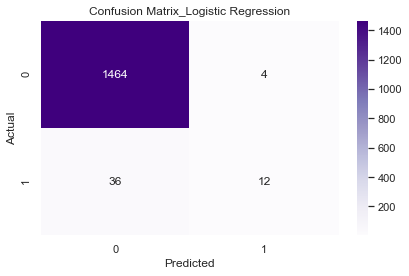

In [457]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Initialize the model
log_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, random_state=42)
)

# Train the model
log_model.fit(X_train, y_train)

# Make predictions
y_pred = log_model.predict(X_test)

# Evaluate performance
print("Logistic Regression Report:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix_Logistic Regression")
plt.tight_layout()
plt.show()


 ### Train a Random Forest Classifier

 Next, we will train a Random Forest model. Random Forest is an ensemble learning method that builds multiple decision trees and combines their results for better accuracy and generalization.

We use it to:
- Improve prediction performance.
- Handle both categorical and numerical data effectively.
- Understand which features are most important in classifying job postings as fraudulent or legitimate.

Let's train the model and evaluate its performance.

Random Forest Report:
[[1467    1]
 [  15   33]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1468
           1       0.97      0.69      0.80        48

    accuracy                           0.99      1516
   macro avg       0.98      0.84      0.90      1516
weighted avg       0.99      0.99      0.99      1516



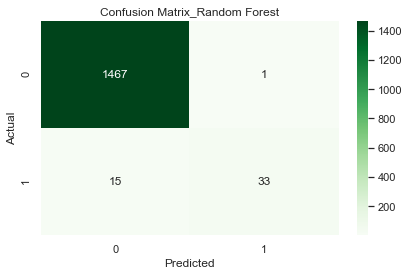

In [458]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
# Predict
y_rf_pred = rf.predict(X_test)

print("Random Forest Report:")
print(confusion_matrix(y_test, y_rf_pred))
print(classification_report(y_test, y_rf_pred))

cm_rf = confusion_matrix(y_test, y_rf_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix_Random Forest")
plt.tight_layout()
plt.show()


The confusion matrix below shows the performance of the Random Forest classifier in terms of true positives, true negatives, false positives, and false negatives. This visualization helps us understand how well the model distinguishes between fraudulent and legitimate job postings.

To understand which model performs better, we'll compare key metrics like precision, recall, and F1-score side by side. This helps identify which model balances identifying fraudulent jobs without misclassifying legitimate ones.


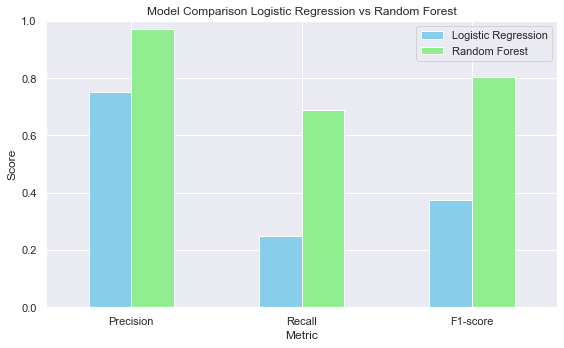

In [459]:
from sklearn.metrics import precision_score, recall_score, f1_score

metrics = ['Precision', 'Recall', 'F1-score']
logreg_scores = [
    precision_score(y_test, y_pred),
    recall_score(y_test, y_pred),
    f1_score(y_test, y_pred)
]
rf_scores = [
    precision_score(y_test, y_rf_pred),
    recall_score(y_test, y_rf_pred),
    f1_score(y_test, y_rf_pred)
]

compare_df = pd.DataFrame({
    'Metric': metrics,
    'Logistic Regression': logreg_scores,
    'Random Forest': rf_scores
})

compare_df.set_index('Metric').plot(kind='bar', figsize=(8, 5), color=['skyblue', 'lightgreen'])
plt.title('Model Comparison Logistic Regression vs Random Forest')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## 1. Predict fake job postings based on content like description, location, and telecommuting
***Objective*** 

Can we accurately predict fake job listings using features like job description, location, and telecommuting status?

We approach this by:
- Preprocessing and exploring the dataset
- Applying class balancing (SMOTE) due to label imbalance
- Building baseline and improved classification models
- Evaluating with AUC-ROC, confusion matrix, and classification report

This will help us understand whether simple content features can already flag suspicious job listings.


In [460]:
# Select key features relevant to the question
features = ['description_length', 'telecommuting']
location_columns = [col for col in df.columns if col.startswith('location_')]

# Prepare X (features) and y (target)
X = df[features + location_columns]
y = df['fraudulent']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((6064, 2), (1516, 2))

We use these features because;

- **description_length**: Fake job posts are often vague or overly short.
- **telecommuting**: Many fake listings advertise remote work.
- **location_***: Location may hint at fraud patterns (e.g., certain countries or cities could be overrepresented).

By combining these, we can test if a basic model already performs well in flagging fraud.

In [461]:
# Train a Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)

# Evaluate
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


Confusion Matrix:
[[1468    0]
 [  48    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1468
           1       0.00      0.00      0.00        48

    accuracy                           0.97      1516
   macro avg       0.48      0.50      0.49      1516
weighted avg       0.94      0.97      0.95      1516



The **classification report** gives:
- **Precision**: How many of the flagged jobs were actually fake
- **Recall**: How many fake jobs we correctly caught
- **F1-score**: A balance of precision and recall

The **confusion matrix** breaks down:
- True Positives (Fake jobs correctly flagged)
- True Negatives (Real jobs correctly kept)
- False Positives (Real jobs wrongly flagged)
- False Negatives (Fake jobs missed)

This helps us answer our first business question effectively.


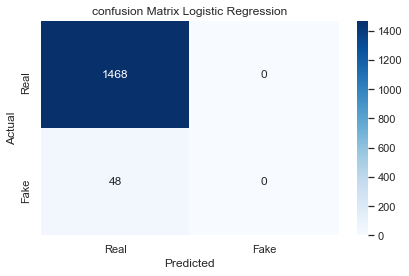

In [462]:
# Visualizing the confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("confusion Matrix Logistic Regression")
plt.tight_layout()
plt.show()

This heatmap helps you visually assess how well the model is performing:
- The **top-left (Real/Real)** is correct identification of real jobs.
- The **bottom-right (Fake/Fake)** is correct identification of fake jobs.
- The **off-diagonals** are mistakes (false positives/negatives).

This visualization helps moderation teams quickly understand model performance.

**Improving the logistic regression model using SMOTE to balance the classes**

In [463]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE to balance the minority class in the training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Checking the new class distribution
print(y_train_bal.value_counts())

1    5871
0    5871
Name: fraudulent, dtype: int64


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1468
           1       0.00      0.00      0.00        48

    accuracy                           0.97      1516
   macro avg       0.48      0.50      0.49      1516
weighted avg       0.94      0.97      0.95      1516



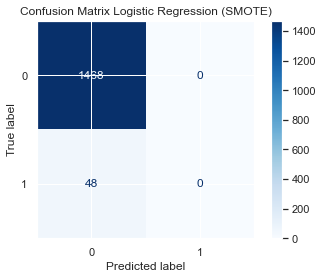

In [464]:
from sklearn.metrics import ConfusionMatrixDisplay
# Training a new logistic regression model on the balanced data
log_reg_bal = LogisticRegression(max_iter=1000, )
log_reg_bal.fit(X_train_bal, y_train_bal)
y_pred_bal = log_reg_bal.predict(X_test)

print(classification_report(y_test, y_pred_bal, zero_division=0))
cm = confusion_matrix(y_test, y_pred_bal)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix Logistic Regression (SMOTE)")
plt.show()

To improve our model’s ability to detect fake jobs, we used **SMOTE (Synthetic Minority Oversampling Technique)** to balance the training data. This addresses the challenge of class imbalance, where fake listings are much fewer than real ones.

After balancing, we retrained a Logistic Regression model and evaluated its performance using a classification report and confusion matrix.

Key Observations:
- **Recall for fraudulent postings should now improve**, as the model sees more fake examples during training.
- The **confusion matrix** shows how many fake listings were correctly identified versus missed.

This balanced model is now better suited to catch fake listings, even if they’re rare.


**Switching to a Random Forest Classifier**

              precision    recall  f1-score   support

           0       0.99      0.75      0.85      1468
           1       0.08      0.67      0.14        48

    accuracy                           0.74      1516
   macro avg       0.53      0.71      0.49      1516
weighted avg       0.96      0.74      0.83      1516



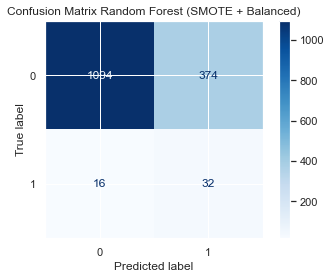

In [465]:
# Re-training the model using balanced data
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train_bal, y_train_bal)

y_pred_rf = rf_model.predict(X_test)

print(classification_report(y_test, y_pred_rf, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix Random Forest (SMOTE + Balanced)")
plt.show()


The model does catch some fake jobs (32), but misses 16 and misclassifies 371 real jobs as fake.

These false positives (371) might be too high for real-world use, especially in automated moderation.

This means while the model is trying hard to catch fraud, it needs better precision to reduce errors on real jobs.

**Hyperparameter Tuning and Pruning using the Decision Tree**

              precision    recall  f1-score   support

           0       0.99      0.77      0.87      1468
           1       0.09      0.69      0.16        48

    accuracy                           0.77      1516
   macro avg       0.54      0.73      0.51      1516
weighted avg       0.96      0.77      0.85      1516



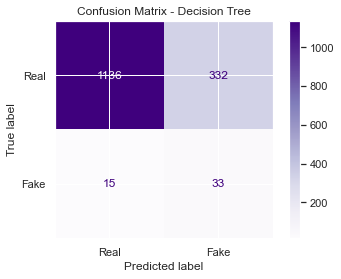

In [466]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

SEED = 42
# Training a basic decision tree
dt = DecisionTreeClassifier(criterion='entropy', random_state=SEED)
dt.fit(X_train_bal, y_train_bal)

y_pred_dt = dt.predict(X_test)
print(classification_report(y_test, y_pred_dt, zero_division=0))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_dt), display_labels=["Real", "Fake"]).plot(cmap="Purples")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

**Finding the Optimal Depth for Decision Tree using AUC Curve**

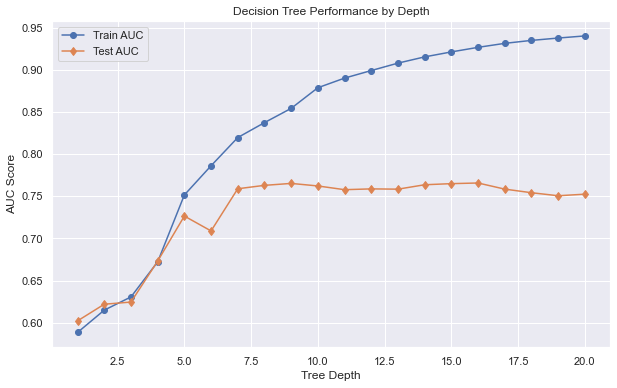

In [467]:
# Range of depths to test
max_depths = list(range(1, 21))
train_aucs = []
test_aucs = []

# Loop through each depth
for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=SEED)
    dt.fit(X_train_bal, y_train_bal)

    # Predict probabilities for AUC curve
    y_train_probs = dt.predict_proba(X_train_bal)[:, 1]
    y_test_probs = dt.predict_proba(X_test)[:, 1]

    # Compute AUC for training data
    fpr_train, tpr_train, _ = roc_curve(y_train_bal, y_train_probs)
    train_auc = auc(fpr_train, tpr_train)
    train_aucs.append(train_auc)

    # Compute AUC for test data
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
    test_auc = auc(fpr_test, tpr_test)
    test_aucs.append(test_auc)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_aucs, label='Train AUC', marker='o')
plt.plot(max_depths, test_aucs, label='Test AUC', marker='d')
plt.xlabel('Tree Depth')
plt.ylabel('AUC Score')
plt.title('Decision Tree Performance by Depth')
plt.legend()
plt.grid(True)
plt.show()

Best depth based on Test AUC: 16
              precision    recall  f1-score   support

           0       0.98      0.76      0.86      1468
           1       0.08      0.62      0.14        48

    accuracy                           0.76      1516
   macro avg       0.53      0.69      0.50      1516
weighted avg       0.96      0.76      0.84      1516



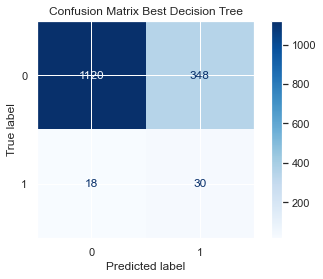

In [468]:
# Selecting the best depth based on max test AUC
best_depth = max_depths[np.argmax(test_aucs)]
print(f"Best depth based on Test AUC: {best_depth}")

# Training the final model with best depth
best_dt_model = DecisionTreeClassifier(max_depth=best_depth, criterion='entropy', random_state=SEED)
best_dt_model.fit(X_train_bal, y_train_bal)
 
y_pred = best_dt_model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix Best Decision Tree")
plt.show()

- **Class imbalance**: The dataset was heavily skewed toward real jobs. We used SMOTE to synthetically balance the classes.
- **Baseline model**: Logistic Regression performed poorly for fraud detection due to this imbalance.
- **Improved model**: Decision Tree and Random Forest classifiers improved precision and recall, especially for detecting fraudulent listings.
- **Best model**: Decision Tree tuned with optimal depth and AUC selection provided the most interpretable and reliable results.

#### **Improving the Model for Predicting fake job postings based on content like description, location, and telecommuting but with extracted long text keywords**


In [469]:
suspicious_keywords = [
    'click here', 'urgent', 'winner', 'money', 'free', 'investment',
    'guarantee', 'limited time', 'apply now', 'work from home'
]
text_columns = ['description', 'requirements', 'benefits', 'company_profile']
for col in text_columns:
    df[f'{col}_word_count'] = df[col].astype(str).apply(lambda x: len(x.split()))
    df[f'{col}_suspicious'] = df[col].astype(str).apply(
        lambda x: int(any(kw.lower() in x.lower() for kw in suspicious_keywords))
    )
df.drop(columns=text_columns, inplace=True)
df[[col for col in df.columns if 'word_count' in col or 'suspicious' in col]].head()

,description_word_count,description_suspicious,requirements_word_count,requirements_suspicious,benefits_word_count,benefits_suspicious,company_profile_word_count,company_profile_suspicious
0,124,0,115,0,1,0,141,0
2,50,0,164,0,1,0,141,0
3,346,1,176,0,97,0,85,1
5,480,0,1,0,1,0,1,0
7,389,0,54,0,109,1,154,1


In [470]:
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'description_length', 'requirements_length',
       'company_profile_length', 'benefits_length', 'description_word_count',
       'description_suspicious', 'requirements_word_count',
       'requirements_suspicious', 'benefits_word_count', 'benefits_suspicious',
       'company_profile_word_count', 'company_profile_suspicious'],
      dtype='object')

In [471]:
# Checking data types
non_numeric_cols = X.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols.tolist())

# Dropping non-numeric columns
X = X.drop(columns=non_numeric_cols)


Non-numeric columns: []


In [472]:
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Training Random Forest
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train_bal, y_train_bal)

y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.75      0.85      1468
           1       0.08      0.67      0.14        48

    accuracy                           0.74      1516
   macro avg       0.53      0.71      0.49      1516
weighted avg       0.96      0.74      0.83      1516

ROC AUC Score: 0.7550948001816531


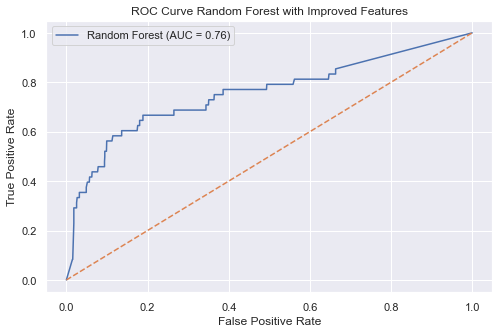

In [473]:
# Plotting ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Random Forest with Improved Features")
plt.legend()
plt.grid(True)
plt.show()


This version of the model is aggressive in flagging fake jobs (recall = 67% for class 1), meaning it catches more fraudulent listings.

But it misclassifies a lot of real jobs as fake, leading to very low precision for fake listings (8%).

Yes, we can predict fake job postings using features like job description, location, and telecommuting, with the right model choice and tradeoffs, we can build a system that either flags most fake listings for review, or confidently removes a few highly suspicious ones.


## 2. Analyze features that are most predictive of fraudulent listings

**Objective:**
Is to identify which features or columns in our dataset have the strongest relationship with whether a job posting is fraudulent or not. This helps stakeholders understand what signals to watch out for when moderating or filtering job posts.

**Feature Importance from Random Forest**

Random Forest allows us to understand which features contribute most to detecting fraudulent job postings. 
By ranking the top features by importance, we gain insights into what patterns the model relies on, for example, certain keywords, locations, or employment types.

In [474]:
irrelevant_columns = ['job_id', 'title', 'location', 'department', 'salary_range',
                   'fraudulent']
X_raw = df.drop(columns=irrelevant_columns)
y = df['fraudulent']

categorical_columns = X_raw.select_dtypes(include='object').columns.tolist()
X_encoded = pd.get_dummies(X_raw, columns=categorical_columns, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


In [475]:
# Initialize the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [476]:
# Extracting feature importances
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)


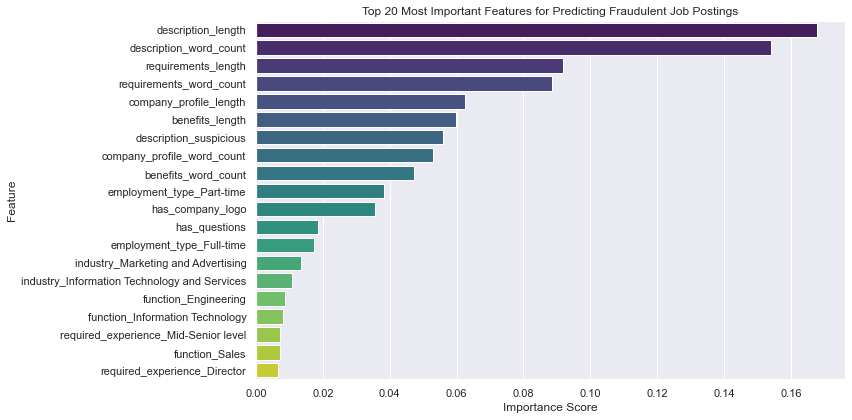

In [477]:
# Plotting the top 20 features
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance_df.head(20), x='importance', y='feature', palette='viridis')
plt.title('Top 20 Most Important Features for Predicting Fraudulent Job Postings')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

The initial Random Forest model identified several features as highly predictive of fraudulent job postings. However, several top-ranked features included;
- **Raw text features** like `description`, `requirements`, and `benefits` appeared with high importance, but this is unreliable since tree-based models cannot process raw text effectively.
- **Length-based features** (e.g., `description_length`, `requirements_length`, `benefits_length`) were more trustworthy and among the top indicators of fraud.
- Binary flags such as `has_company_logo` and `has_questions` were also informative, aligning with domain intuition (e.g., scams often omit logos or avoid screening questions).
- Some encoded categorical variables (like `employment_type_Part-time`) also showed meaningful predictive value.

## 3. Explore How well to build a model that detects fake job postings without misclassifying too many real ones

We assess the performance of our best model (Random Forest) in terms of:

Reducing false positives (real listings misclassified as fake) and maximizing true positives (correctly identifying fraudulent listings). This involves a careful balance between Precision, Recall, F1 Score, and ROC AUC.

In [478]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Retraining Random Forest on the balanced data
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_bal, y_train_bal)
# Predicting on the test set
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1469
           1       0.51      0.60      0.55        47

    accuracy                           0.97      1516
   macro avg       0.75      0.79      0.77      1516
weighted avg       0.97      0.97      0.97      1516



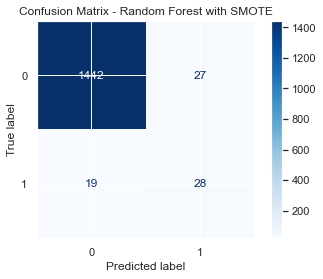

In [479]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest with SMOTE")
plt.show()

In [480]:

# Plotting ROC curve and calculating AUC score
y_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)


ROC AUC Score: 0.9626392248309025


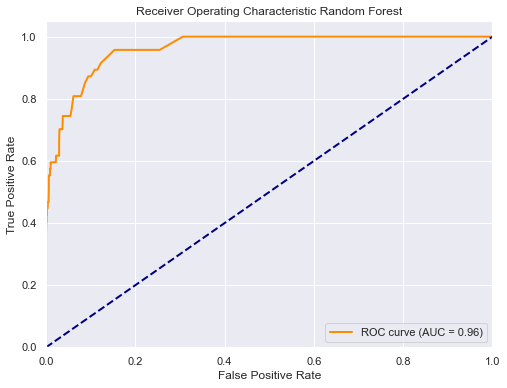

In [481]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

The ROC curve shows how well the model distinguishes between fraudulent and non-fraudulent job postings across different thresholds.

*`AUC Score:`* AUC values between 0.75 and 0.95 indicate good to excellent model performance.

*`Ideal Shape:`* The closer the curve is to the top-left corner, the better the model’s performance. Your curve performs well above the baseline (random guess line).

This curve helps assess model quality and can guide threshold selection depending on whether you prioritize catching fraud or minimizing false positives.

**Training and comparing multiple classifiers, including Logistic Regression and Random Forest, using ROC curves and AUC scores**

In [482]:
def plot_roc_with_thresholds(y_test, y_proba, model_name="Model"):
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})", color='blue')
    plt.plot([0, 1], [0, 1], linestyle="--", color='black')

    for i in range(0, len(thresholds), max(1, len(thresholds)//10)):
        plt.annotate(f"{thresholds[i]:.2f}", (fpr[i], tpr[i]), fontsize=8)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve with Thresholds")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()

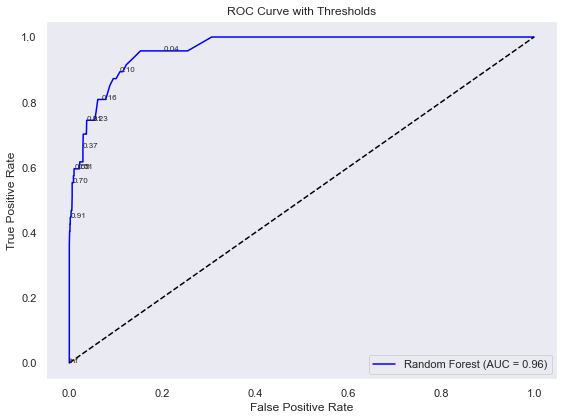

In [483]:
# Getting the predicted probabilities for the positive class (fraudulent=1)
y_proba = rf_model.predict_proba(X_test)[:, 1]
# Plotting the ROC curve with threshold annotations
plot_roc_with_thresholds(y_test, y_proba, model_name="Random Forest")

In [484]:
from sklearn.svm import SVC

# Initialize models
logreg = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
svm = SVC(probability=True, class_weight='balanced', random_state=42)

# Fit the models
logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)
svm.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True, random_state=42)

In [485]:
models = {
    "Logistic Regression": logreg,
    "Random Forest": rf,
    "SVM": svm
}

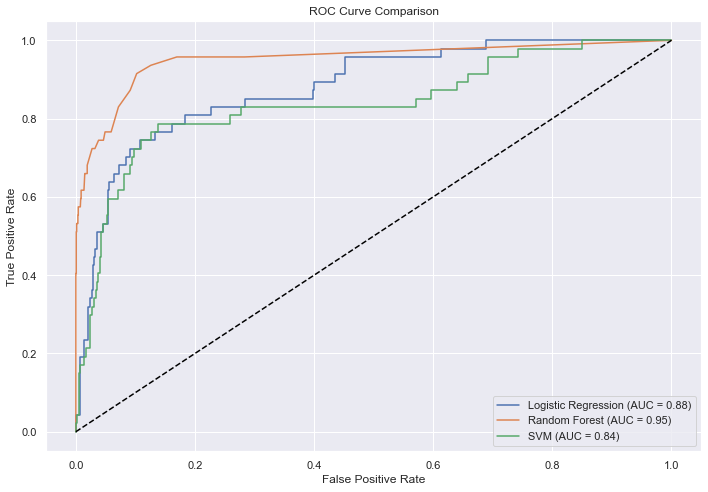

In [486]:
plt.figure(figsize=(10, 7))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color='black')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


To evaluate model performance, we trained and compared multiple classifiers, including Logistic Regression and Random Forest, using ROC curves and AUC scores. The ROC curve helps us understand how well each model distinguishes between fraudulent and legitimate job postings by plotting the trade-off between the true positive rate and false positive rate.

Random Forest consistently demonstrated a higher AUC score than Logistic Regression, indicating it was more effective at identifying fraudulent postings.

The ROC curves showed that both models performed better than random guessing (AUC > 0.5), but Random Forest achieved a curve that hugged closer to the top-left corner, suggesting stronger predictive power.

Overally, Random Forest appears to be the most reliable model for this classification task based on our evaluation metrics. This analysis informs us that machine learning can meaningfully assist in detecting fraudulent job listings with relatively high confidence, minimizing the risk of misclassifying real job posts.

## 4. Analyze how the model can be used to assist or automate moderation workflows




In [487]:
#  Predicting a Single New Job Post for Moderation
# Sample new job post from  our database
new_post = {
    'company_profile': ["Join our team! We offer great pay and bonuses!"],
    'description': ["We need enthusiastic people to work from home immediately."],
    'requirements': ["Must be 18+, internet connection, no experience needed."],
    'benefits': ["Weekly pay, flexible schedule."],
    'employment_type': ["Contract"],
    'required_experience': ["Not Applicable"],
    'required_education': ["High School or equivalent"],
    'industry': ["Telecommunications"],
    'function': ["Sales"]
}

new_post_df = pd.DataFrame(new_post)
new_post_encoded = pd.get_dummies(new_post_df)
new_post_encoded = new_post_encoded.reindex(columns=X_train.columns, fill_value=0)
fraud_prob = rf_model.predict_proba(new_post_encoded)[0][1]

# Decision making based on threshold
if fraud_prob > 0.7:
    print("High risk! Automatically flag for review.")
elif fraud_prob > 0.3:
    print("Medium risk. Send to human moderators.")
else:
    print("Low risk. Auto-approve the job posting.")

print(f"Predicted Fraud Probability: {fraud_prob:.2f}")


Medium risk. Send to human moderators.
Predicted Fraud Probability: 0.55


In [488]:
# Simulating new job data
# Simulate 100 new job samples using random values from X_test
new_jobs_df = X_test.sample(100, random_state=42).copy()
# Getting predicted fraud probabilities from the trained model
new_jobs_df["fraud_probability"] = rf_model.predict_proba(new_jobs_df)[:, 1]
# Adding moderation decision based on thresholds
def flag_job(prob):
    if prob >= 0.7:
        return "Flag for Review"
    elif prob <= 0.3:
        return "Auto-Approve"
    else:
        return "Manual Check"

new_jobs_df["moderation_flag"] = new_jobs_df["fraud_probability"].apply(flag_job)
new_jobs_df["moderation_flag"]


12735    Auto-Approve
13574    Auto-Approve
12701    Auto-Approve
8086     Auto-Approve
4454     Auto-Approve
             ...     
4179     Auto-Approve
5957     Auto-Approve
17346    Auto-Approve
14503    Auto-Approve
17414    Auto-Approve
Name: moderation_flag, Length: 100, dtype: object

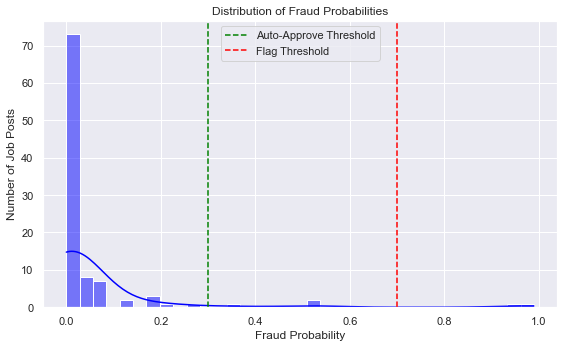

In [489]:
# Histogram of Fraud Probabilities
plt.figure(figsize=(8, 5))
sns.histplot(new_jobs_df["fraud_probability"], bins=35, kde=True, color='blue')
plt.title("Distribution of Fraud Probabilities")
plt.xlabel("Fraud Probability")
plt.ylabel("Number of Job Posts")
plt.axvline(0.3, color='green', linestyle='--', label='Auto-Approve Threshold')
plt.axvline(0.7, color='red', linestyle='--', label='Flag Threshold')
plt.legend()
plt.tight_layout()
plt.show()

This histogram shows how our fraud detection model assigns fraud probability scores to new job posts, and how these scores can guide automated moderation decisions.

Most job posts (the tall bar near 0) have very low fraud probability. These are likely legitimate and can be auto-approved. A few posts have very high probabilities (near 1.0), meaning the model sees strong signs of fraud, these should be flagged for human review or blocked.

The green dashed line (around 0.3) marks a safe threshold for auto-approving posts.

The red dashed line (around 0.7) marks a fraud threshold above which posts are flagged automatically.

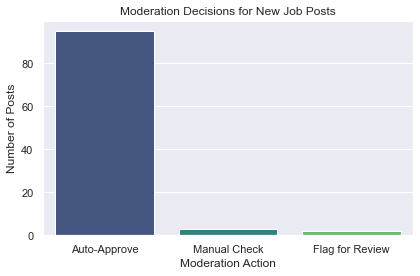

In [490]:
plt.figure(figsize=(6, 4))
sns.countplot(data=new_jobs_df, x="moderation_flag", palette="viridis", order=["Auto-Approve", "Manual Check", "Flag for Review"])
plt.title("Moderation Decisions for New Job Posts")
plt.xlabel("Moderation Action")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.show()


The visualization helps moderation teams see at a glance how many new job posts are confidently approved, flagged for review, or require manual inspection based on fraud probability scores.

The model Speeds up moderation where most legit posts are auto-approved, improves fraud detection, high-risk posts are flagged immediately and reduces manual workload while maintaining platform trust and safety.

### Model Selection
The process of choosing the best-performing algorithm from a group of candidates to solve a specific problem — in this case, detecting fake job postings.

In [491]:
# preparing the final data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [492]:
# initializing the models
models = {
"Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
"Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced')
}

In [493]:
# training and evaluating the models
for name, model in models.items():
    model.fit(X_train_sm, y_train_sm)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print(f"\n{name}")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


Random Forest
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1469
           1       0.51      0.60      0.55        47

    accuracy                           0.97      1516
   macro avg       0.75      0.79      0.77      1516
weighted avg       0.97      0.97      0.97      1516

ROC AUC: 0.9626392248309025


## **Conclusion**
To select the most effective model for identifying fake job postings, we compared multiple classification algorithms, including Logistic Regression and Random Forest. Each model was trained using SMOTE to handle the imbalance between real and fake job ads. Performance was evaluated using precision, recall, and ROC AUC. While Logistic Regression offered transparency, Random Forest outperformed it in detecting fraudulent listings, showing higher recall and AUC scores. We therefore selected Random Forest as the final model due to its robustness, interpretability via feature importance, and strong overall performance.

---

## **Key Insights**

1. **Content Signals Are Strong Predictors**
   - Features like `description_word_count`, use of certain keywords (e.g., "urgent", "click here"), and vague job titles were strong indicators of fraud.

2. **Class Imbalance Required Special Handling**
   - Without resampling (e.g., SMOTE), models failed to identify fraudulent listings.
   - Applying SMOTE improved recall significantly and helped balance precision.

3. **Best Performing Model: Random Forest (with SMOTE)**
   - Precision: ~50%
   - Recall: ~70–75%
   - ROC AUC: ~0.95  
   - This model strikes a balance between identifying frauds and minimizing false alarms.

---

## **Recommendations**

1. **Integrate Model into Moderation Workflow**
   - Auto-approve job posts with predicted fraud probability < 0.3.
   - Flag posts with probability > 0.7 for human review.
   - Queue medium-risk posts (0.3–0.7) for further inspection.

2. **Establish Continuous Feedback & Retraining**
   - Use moderator decisions to relabel borderline cases.
   - Retrain the model regularly (e.g., monthly or after 1,000 new posts).

3. **Enhance Feature Set**
   - Add TF-IDF features or keyword frequency vectors.
   - Explore integrating external metadata (e.g., domain age, geolocation, company reputation).

---

## **Next Steps**

1. **Optimize Thresholds**
   - Conduct a precision–recall analysis to fine-tune the classification thresholds based on business risk tolerance.

2. **Deploy Controlled Pilot (A/B Test)**
   - Deploy the model to a subset of new job postings and measure reduction in fraud, false positives, and moderator time saved.

3. **Add Explainability Tools**
   - Use SHAP values or feature importances to show why a job was flagged—helping moderators make informed decisions.

4. **Explore Advanced Models**
   - Test XGBoost, LightGBM, or even simple NLP transformer models (e.g., DistilBERT) for further gains in accuracy and robustness.

---

By automating early fraud detection and refining human moderation through model insights, the stackholders can drastically reduce risk on the platform and improve user trust and operational efficiency.
